# Lab3 ResNet18

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import copy
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.4.0
True


## DataSet & DataLoader
data augmentation:  
1. RandomHorizontalFlip
2. RandomVerticalFilp
3. Normalize each channel(R,G,B)

In [2]:
class RetinopathyDataSet(Dataset):
    def __init__(self, img_path, mode):
        """
        Args:
            img_path: Root path of the dataset.
            mode: training/testing
            
            self.img_names (string list): String list that store all image names.
            self.labels (int or float list): Numerical list that store all ground truth label values.
        """
        self.img_path = img_path
        self.mode = mode
        
        self.img_names=np.squeeze(pd.read_csv('train_img.csv' if mode=='train' else 'test_img.csv').values)
        self.labels=np.squeeze(pd.read_csv('train_label.csv' if mode=='train' else 'test_label.csv').values)
        assert len(self.img_names)==len(self.labels),'length not the same'
        self.data_len=len(self.img_names)
        
        self.transformations=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                                transforms.Normalize((0.3749, 0.2602, 0.1857),(0.2526, 0.1780, 0.1291))])
        print(f'>> Found {self.data_len} images...')
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        single_img_name=os.path.join(self.img_path,self.img_names[index]+'.jpeg')
        single_img=Image.open(single_img_name)  # read an PIL image
        img=self.transformations(single_img)
        label=self.labels[index]
        
        return img, label

## Model
1. ResNet18 (with/wo pretrained weights)
2. ResNet50 (with/wo pretrained weights)

reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks  

In [3]:
class ResNet18(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet18,self).__init__()
        self.model=models.resnet18(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out
    
class ResNet50(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet50,self).__init__()
        self.model=models.resnet50(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out

## Train & Evaluate

In [4]:
def train(model,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,name):
    """
    Args:
        model: resnet model
        loader_train: training dataloader
        loader_test: testing dataloader
        Loss: loss function
        optimizer: optimizer
        epochs: number of training epoch
        device: gpu/cpu
        num_class: #target class
        name: model name when saving model
    Returns:
        dataframe: with column 'epoch','acc_train','acc_test'
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    best_model_wts=None
    best_evaluated_acc=0
    
    model.to(device)
    acc_train=list()
    acc_test=list()
    for epoch in range(1,epochs+1):
        """
        train
        """
        with torch.set_grad_enabled(True):
            model.train()
            total_loss=0
            correct=0
            for images,targets in loader_train:
                images,targets=images.to(device),targets.to(device,dtype=torch.long)
                predict=model(images)
                loss=Loss(predict,targets)
                total_loss+=loss.item()
                correct+=predict.max(dim=1)[1].eq(targets).sum().item()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward()  # bp
                optimizer.step()
            total_loss/=len(loader_train.dataset)
            acc=100.*correct/len(loader_train.dataset)
            acc_train.append(acc)
            print(f'epoch{epoch:>2d} loss:{total_loss:.4f} acc:{acc:.2f}%')
        """
        evaluate
        """
        _,acc=evaluate(model,loader_test,device,num_class)
        acc_test.append(acc)
        # update best_model_wts
        if acc>best_evaluated_acc:
            best_evaluated_acc=acc
            best_model_wts=copy.deepcopy(model.state_dict())
    
    df['acc_train']=acc_train
    df['acc_test']=acc_test
    
    # save model
    torch.save(best_model_wts,os.path.join('models',name+'.pt'))
    model.load_state_dict(best_model_wts)
    
    return df

In [5]:
def evaluate(model,loader_test,device,num_class):
    """
    Args:
        model: resnet model
        loader_test: testing dataloader
        device: gpu/cpu
        num_class: #target class
    Returns:
        confusion_matrix: (num_class,num_class) ndarray
        acc: accuracy rate
    """
    confusion_matrix=np.zeros((num_class,num_class))
    
    with torch.set_grad_enabled(False):
        model.eval()
        correct=0
        for images,targets in loader_test:  
            images,targets=images.to(device),targets.to(device,dtype=torch.long)
            predict=model(images)
            predict_class=predict.max(dim=1)[1]
            correct+=predict_class.eq(targets).sum().item()
            for i in range(len(targets)):
                confusion_matrix[int(targets[i])][int(predict_class[i])]+=1
        acc=100.*correct/len(loader_test.dataset)
        
    # normalize confusion_matrix
    confusion_matrix=confusion_matrix/confusion_matrix.sum(axis=1).reshape(num_class,1)
    
    return confusion_matrix,acc

## Plot

In [6]:
def plot(dataframe1,dataframe2,title):
    """
    Arguments:
        dataframe1: dataframe with 'epoch','acc_train','acc_test' columns of without pretrained weights model 
        dataframe2: dataframe with 'epoch','acc_train','acc_test' columns of with pretrained weights model 
        title: figure's title
    Returns:
        figure: an figure
    """
    fig=plt.figure(figsize=(10,6))
    for name in dataframe1.columns[1:]:
        plt.plot(range(1,1+len(dataframe1)),name,data=dataframe1,label=name[4:]+'(w/o pretraining)')
    for name in dataframe2.columns[1:]:
        plt.plot(range(1,1+len(dataframe2)),name,data=dataframe2,label=name[4:]+'(with pretraining)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend()
    return fig

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    ax.xaxis.set_label_position('top')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(i, j, '{:.2f}'.format(confusion_matrix[j, i]), va='center', ha='center')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    return fig

## Hyperparameters
__num_class__: 5  
__batch_size:__  
1. Resnet18: 64
2. Resnet50: 16

__learning rate:__ 1e-3  
__Epochs:__  
1. model wo pretrained weights: 15
2. model with pretrained weights: 5(feature extraction) + 10(finetuning)

__Optimizer:__ SGD,momentum=0.9,weight_decay=5e-4  
__loss function:__ cross entropy  

In [7]:
num_class=5
batch_size=64
lr=1e-3
epochs=20
epochs_feature_extraction=5
epochs_fine_tuning=15
momentum=0.9
weight_decay=5e-4
Loss=nn.CrossEntropyLoss()

# Run ResNet18

In [8]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.0140 acc:72.91%
epoch 2 loss:0.0135 acc:73.50%
epoch 3 loss:0.0134 acc:73.48%
epoch 4 loss:0.0134 acc:73.48%
epoch 5 loss:0.0134 acc:73.49%
epoch 6 loss:0.0133 acc:73.47%
epoch 7 loss:0.0132 acc:73.53%
epoch 8 loss:0.0132 acc:73.48%
epoch 9 loss:0.0132 acc:73.45%
epoch10 loss:0.0132 acc:73.54%
epoch11 loss:0.0131 acc:73.50%
epoch12 loss:0.0131 acc:73.50%
epoch13 loss:0.0130 acc:73.48%
epoch14 loss:0.0131 acc:73.49%
epoch15 loss:0.0130 acc:73.50%
epoch16 loss:0.0130 acc:73.52%
epoch17 loss:0.0130 acc:73.50%
epoch18 loss:0.0130 acc:73.54%
epoch19 loss:0.0130 acc:73.51%
epoch20 loss:0.0130 acc:73.49%
epoch 1 loss:0.0131 acc:73.52%
epoch 2 loss:0.0124 acc:73.74%
epoch 3 loss:0.0121 acc:73.99%
epoch 4 loss:0.0121 acc:74.20%
epoch 5 loss:0.0120 acc:74.32%
epoch 1 loss:0.0110 acc:76.14%
epoch 2 loss:0.0098 acc:78.88%
epoch 3 loss:0.0094 acc:79.96%
epoch 4 loss:0.0089 acc:80.74%
epoch 5 loss:0.0087 acc:81.43%
epoch 6 loss:0.0084 acc:81.90%
epoch 7 loss:0.0081 acc:82.72%
epoch 8 

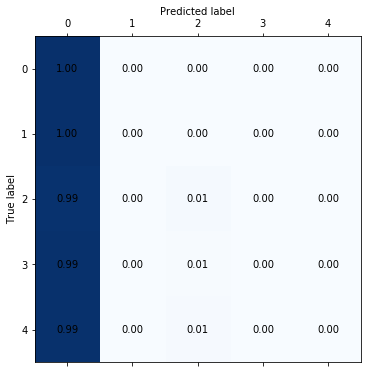

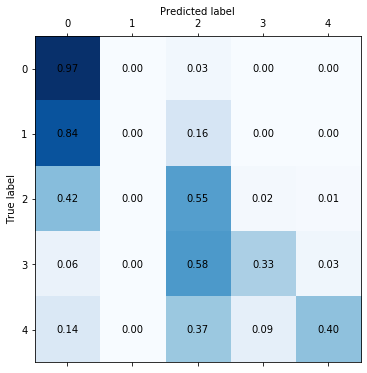

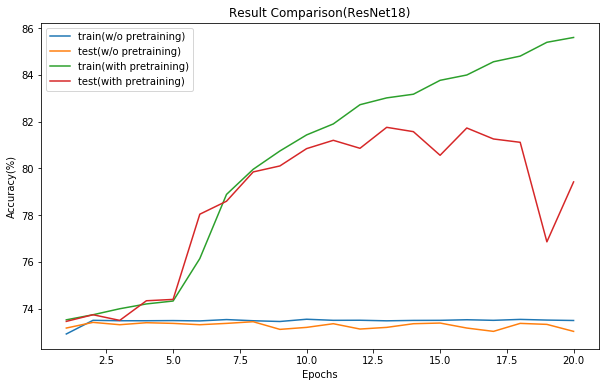

In [9]:
"""
resnet18 without pretrained weights
"""
model_wo=ResNet18(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet18_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (wo pretrained weights).png')

"""
resnet18 with pretrained weights
    feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet18(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet18_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet18_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_wo_pretrained,df_with_pretrained,'Result Comparison(ResNet18)')
figure.savefig('Result Comparison(ResNet18).png')

In [10]:
print(df_wo_pretrained)
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  72.913627  73.167260
1       2  73.497277  73.409253
2       3  73.479483  73.309609
3       4  73.479483  73.395018
4       5  73.486601  73.366548
5       6  73.472366  73.309609
6       7  73.529307  73.366548
7       8  73.479483  73.437722
8       9  73.447454  73.110320
9      10  73.543542  73.195730
10     11  73.497277  73.352313
11     12  73.500836  73.124555
12     13  73.475924  73.195730
13     14  73.493719  73.352313
14     15  73.497277  73.380783
15     16  73.522189  73.167260
16     17  73.497277  73.024911
17     18  73.536425  73.366548
18     19  73.507954  73.323843
19     20  73.490160  73.024911
    epoch  acc_train   acc_test
0       1  73.518631  73.451957
1       2  73.735720  73.736655
2       3  73.991957  73.494662
3       4  74.198370  74.334520
4       5  74.322930  74.391459
5       1  76.137941  78.035587
6       2  78.881811  78.590747
7       3  79.956582  79.843416
8       4  80.739528  80.099644
9       

## Run ResNet50

In [11]:
batch_size=16

In [12]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.0587 acc:72.71%
epoch 2 loss:0.0559 acc:73.22%
epoch 3 loss:0.0549 acc:73.33%
epoch 4 loss:0.0547 acc:73.37%
epoch 5 loss:0.0545 acc:73.43%
epoch 6 loss:0.0542 acc:73.43%
epoch 7 loss:0.0540 acc:73.42%
epoch 8 loss:0.0538 acc:73.46%
epoch 9 loss:0.0537 acc:73.48%
epoch10 loss:0.0536 acc:73.49%
epoch11 loss:0.0535 acc:73.49%
epoch12 loss:0.0533 acc:73.50%
epoch13 loss:0.0533 acc:73.50%
epoch14 loss:0.0533 acc:73.47%
epoch15 loss:0.0531 acc:73.49%
epoch16 loss:0.0532 acc:73.50%
epoch17 loss:0.0532 acc:73.50%
epoch18 loss:0.0529 acc:73.50%
epoch19 loss:0.0529 acc:73.49%
epoch20 loss:0.0528 acc:73.51%
epoch 1 loss:0.0523 acc:73.51%
epoch 2 loss:0.0496 acc:73.69%
epoch 3 loss:0.0488 acc:74.12%
epoch 4 loss:0.0482 acc:74.22%
epoch 5 loss:0.0484 acc:74.15%
epoch 1 loss:0.0430 acc:77.19%
epoch 2 loss:0.0375 acc:80.20%
epoch 3 loss:0.0353 acc:81.15%
epoch 4 loss:0.0336 acc:82.20%
epoch 5 loss:0.0320 acc:83.03%
epoch 6 loss:0.0311 acc:83.36%
epoch 7 loss:0.0297 acc:83.94%
epoch 8 

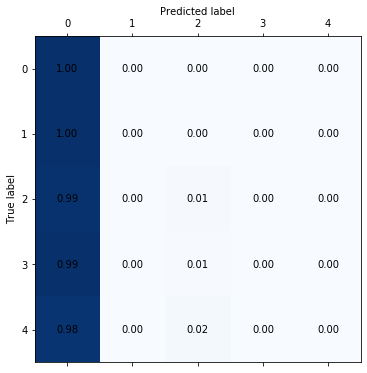

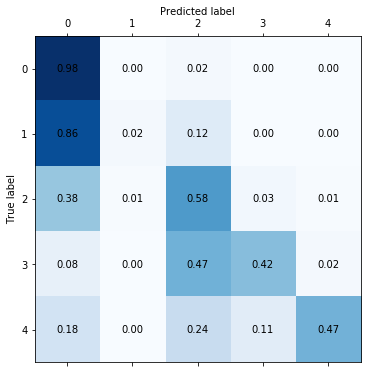

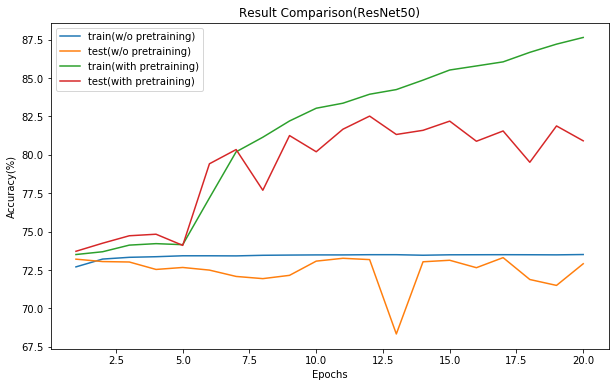

In [13]:
"""
resnet50 without pretrained weights
"""
model_wo=ResNet50(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet50_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (wo pretrained weights).png')

"""
resnet50 with pretrained weights
    first feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet50(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet50_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet50_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_wo_pretrained,df_with_pretrained,'Result Comparison(ResNet50)')
figure.savefig('Result Comparison(ResNet50).png')

In [14]:
print(df_wo_pretrained)
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  72.707214  73.209964
1       2  73.216129  73.053381
2       3  73.330012  73.024911
3       4  73.369159  72.540925
4       5  73.429659  72.669039
5       6  73.429659  72.498221
6       7  73.422542  72.085409
7       8  73.461689  71.943060
8       9  73.475924  72.156584
9      10  73.486601  73.081851
10     11  73.486601  73.266904
11     12  73.500836  73.181495
12     13  73.500836  68.341637
13     14  73.465248  73.039146
14     15  73.493719  73.138790
15     16  73.497277  72.654804
16     17  73.500836  73.309609
17     18  73.497277  71.886121
18     19  73.490160  71.501779
19     20  73.511513  72.911032
    epoch  acc_train   acc_test
0       1  73.511513  73.722420
1       2  73.693014  74.249110
2       3  74.123634  74.733096
3       4  74.219723  74.832740
4       5  74.152105  74.106762
5       1  77.191359  79.416370
6       2  80.195025  80.341637
7       3  81.145236  77.693950
8       4  82.202214  81.252669
9       